In [1]:
import networkx as nx
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
from scipy.stats import poisson

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Networkx è una libreria che permette di lavorare con i grafi e di svolgere analisi di rete. [Documentazione](https://networkx.org/)

In [3]:
brain = nx.read_edgelist("/content/bn-mouse-kasthuri_graph_v4.edges")

## Numero di nodi e archi




In [4]:
len(brain.nodes)

1029

In [5]:
len(brain.edges)

1559

## Density

Calcoliamo la densità della rete

In [6]:
density = nx.density(brain)
density

0.0029475937123042656

La rete non è sparsa quanto quella tipicamente di un social network (10<sup>-6</sup>) ma è comunque molto sparsa

# 1 - Degree Distribution

 Media, mediana, deviazione standard, range interquartile, minimo e massimo sono dei buoni indici per riassumere la distribuzione.

In [8]:
degrees = list(dict(brain.degree()).values())

In [9]:
print('Mean degree: \t​​​​'+ str(np.mean(degrees)))
print('Standard deviation: ​​​​' + str(np.std(degrees)))
print('Median: ' + str(np.median(degrees)))
print('iqr: ' + str(np.quantile(degrees, 0.75) - np.quantile(degrees, 0.25)))
print('Min: ​​​​' + str(np.min(degrees)))
print('Max: ​​​​' + str(np.max(degrees)))


Mean degree: 	​​​​3.0301263362487854
Standard deviation: ​​​​6.286646968804228
Median: 2.0
iqr: 2.0
Min: ​​​​1
Max: ​​​​123


Nelle reti scale free la media è molto più alta della mediana per via degli hub (sono outliers). Nel nostro caso invece i due valori sono vicini ma non coincidono, il che può essere un campanello d'allarme che si tratti di una rete broad-scale.

Costruiamo il random graph (grafo di Erdos and Renyi) relativo al brain network in analisi e che avrà la distribuzione dei single scale (binomiale - Poisson).




In [10]:
random_graph_erdos = nx.fast_gnp_random_graph(len(brain.nodes), nx.density(brain))
len(random_graph_erdos.nodes), len(random_graph_erdos.edges)

(1029, 1603)

In [11]:
random_degrees = list(dict(random_graph_erdos.degree()).values())

Text(0, 0.5, 'ECCDF')

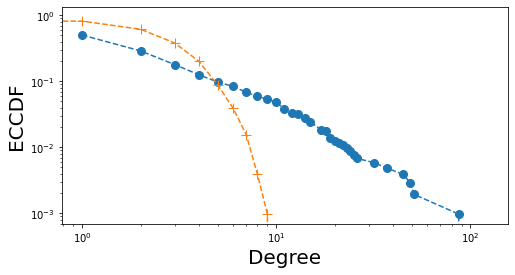

In [12]:
cdf = ECDF(degrees)
x = np.unique(degrees)
y = cdf(x)

cdf_random = ECDF(random_degrees)
x_random = np.unique(random_degrees)
y_random = cdf_random(x_random)
 
fig_cdf_fb = plt.figure(figsize=(8,4))
axes = fig_cdf_fb.gca()
axes.set_xscale('log')
axes.set_yscale('log')
axes.loglog(x,1-y,marker='o',ms=8, linestyle='--')
axes.loglog(x_random,1-y_random,marker='+',ms=10, linestyle='--')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECCDF', size = 20)

La distribuzione dei gradi dei nodi del grafo random è quella stampata in arancione, mentre la distribuzione dei gradi dei nodi del brain network del topo è stampata in blu.

La distribuzione del grafo random segue la distribuzione di Poisson, e non riesce a catturare i  piccoli hub del grafo, la cui presenza è evidenziata dalla distribuzione del grafo originario.


Ma pare pareto? Non mi pare. Gli hub anche se non sono catturati dalla poisson non distano troppo da essa, sono solo di un ordine di grandezza maggiore rispetto alla media calcolata prima. Per questo motivo non si tratta neanche di una rete scale-free ed è sensato dire che stiamo lavorando con una rete broad-scale

Per chi si chiede come mai il plot della distribuzione sia stato fatto usando l'eccdf e la scala loglog, e non un semplice barplot, consiglio di consultare il libro *Network Science* di Barabasi sezione 4.12 argomento avanzato 3b.

Invece per chi è dubbioso che quella plottata prima sia una Poissoniana:

Text(0, 0.5, 'CDF')

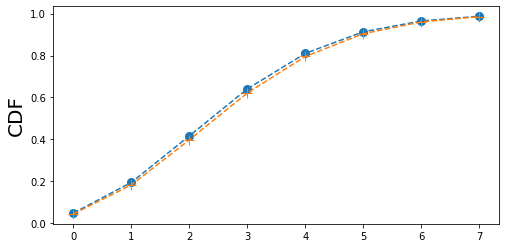

In [14]:
mu = np.mean(degrees)
x = np.arange(poisson.ppf(0.01, mu),poisson.ppf(0.99, mu))
prob = poisson.cdf(x, mu) 

mu_random = np.mean(random_degrees)
x_random = np.arange(poisson.ppf(0.01, mu_random),poisson.ppf(0.99, mu_random))
prob_random = poisson.cdf(x_random, mu_random) 
 

fig_cdf_fb = plt.figure(figsize=(8,4))
axes = fig_cdf_fb.gca()
axes.plot(x,prob,marker='o',ms=8, linestyle='--')
axes.plot(x_random,prob_random,marker='+',ms=10, linestyle='--')
axes.set_ylabel('CDF', size = 20)

# 2 - Connectivity

E' un grafo connesso?

In [15]:
nx.is_connected(brain)

False

## C'è una giant component?

In [17]:
components =  nx.connected_components(brain)
component_list = list(components)

Numero delle componenti connesse:

In [18]:
len(component_list)

20

Tracciamo l'ECDF della distribuzione delle size delle componenti connesse

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


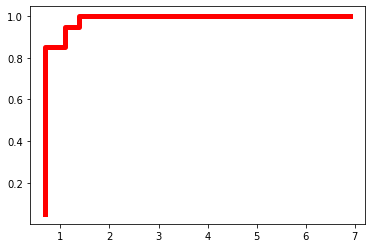

In [21]:
sorted_components = sorted(component_list, key = lambda x : len(x), reverse=True)
len_of_components = list ( map ( lambda x :  len(x) ,sorted_components ))
ecdf = ECDF(len_of_components)
plt.step(np.log(ecdf.x),ecdf.y, color = 'r', linewidth = 5)


Il grafico evidenzia la presenza di una componente connessa che contiene più dell'80% dei nodi.

#3 - Small World

Calcoliamo il diametro della giant component e non dell'intera rete perchè la distanza tra due nodi non connessi è infinito e quindi avremmo un errore sul calcolo del diametro

In [22]:
giant_component = brain.subgraph(sorted_components[0])
nx.diameter(giant_component)

12

Ci conferma che non è proprio small world.